In [1]:
from customNN import NeuralNetwork, ReLU, Dense, softmax_crossentropy_with_logits, grad_softmax_crossentropy_with_logits
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import numpy as np

Using TensorFlow backend.


In [2]:
## Import dataset 

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

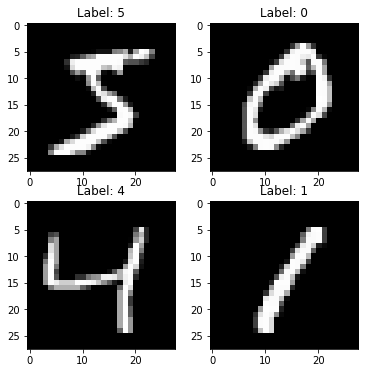

In [3]:
# sample plot 
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')

In [9]:
# build the NeuralNetwork. Note it inherits from list, thus the append method.
network = NeuralNetwork(l2_regularisation=False)
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))
X_train.shape[1]
print('Network object:', network, '\n')

print('Printing weights of last dense layer, at element 5:\n\n', network[-1].get_weights()[5])

Network object: [<customNN.Dense object at 0x7f6283245c50>, <customNN.ReLU object at 0x7f6282d840d0>, <customNN.Dense object at 0x7f6283253650>, <customNN.ReLU object at 0x7f6282d4c350>, <customNN.Dense object at 0x7f6282d3d9d0>] 

Printing weights of last dense layer, at element 5

 [ 4.93437236e-03 -2.70436525e-02 -5.55185797e-03  1.50856026e-05
  8.57093817e-03  1.48114365e-02 -2.19661122e-03  1.50339816e-02
 -1.48238505e-02 -8.56164218e-03]


Epoch 0
Loss: 0.8091687524062364


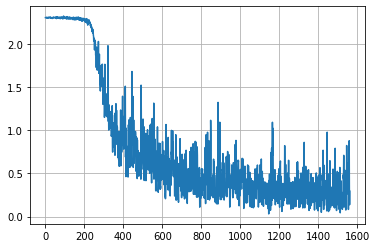

preds [9 3 7 0 9 0 8 5 5 2 4 5 0 8 4 8]


In [5]:
# train, with visualise=True

mean_loss = network.train(X=X_train, y=y_train, epochs=20, batchsize=32, visualise=True, shuffle=False)
weights_iter_1 = network[-1].get_weights()

In [6]:
print(mean_loss)

[0.12521164715886354, 0.12836572128851542, 0.12924857442977192, 0.12698532538015206, 0.11917001175470189, 0.12966452205882353, 0.13475468312324929, 0.13275263230292117, 0.11867715836334534, 0.1254328293817527, 0.13072260154061624, 0.12114126900760305, 0.12124474789915968, 0.12309955232092838, 0.12686027536014405, 0.11877313425370147, 0.129531343787515, 0.12689732142857144, 0.11523203031212484, 0.12269517181872748, 0.13159920218087237, 0.12767888405362143, 0.14326918267306923, 0.1395545718287315, 0.1311859118647459, 0.13442439475790313, 0.13163828031212485, 0.13890071653661465, 0.13427245898359344, 0.12739799044617847, 0.130281487595038, 0.11583070728291317, 0.12039065626250503, 0.10611635279111643, 0.12153564550820325, 0.11466211484593837, 0.11550792191876753, 0.1597137292416967, 0.14540191076430573, 0.16936383928571427, 0.15221635529211686, 0.14719090761304524, 0.16629167291916766, 0.1614417642056823, 0.12817236269507803, 0.1264354179171669, 0.1261390493697479, 0.12236128826530611, 0.

In [6]:
import numpy as np
from customNN import * 
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = [X]
    for n in range(len(network)):
        layer = network[n]
        activations.append(layer.forward(intake=activations[-1]))
    assert len(activations[1:]) == len(network), 'Lens are %s and %s' % (len(activations), len(network) )
    
    return activations[1:]

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y, regularise=False):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
   
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y, regularise=regularise, weights=network[-1].get_weights())
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y, regularised=regularise, weights=network[-1].get_weights())
    #  propagate gradients through the network
    #print('loss_grad, no class', loss_grad)
    
#     for n in range(len(network), 0):  # range(max, 0) is wrong!!! 
    backward_grads = [loss_grad]
    for n in reversed(range(len(network))):
   #         print('network %s' % n)
        layer = network[n]
        # print(layer)
     #    print(layer_inputs[n].shape)
        grads_input = layer.backward(intake=layer_inputs[n], grad_output=backward_grads[-1])
        backward_grads.append(grads_input)    

    return np.mean(loss)



In [7]:
network2 = []
network2.append(Dense(X_train.shape[1],100))
network2.append(ReLU())
network2.append(Dense(100,200))
network2.append(ReLU())
network2.append(Dense(200,10))
X_train.shape[1]

784

In [9]:

assert np.array_equal(network2[-1].get_weights(), network[-1].get_weights()), 'WEIGHTS'
assert np.all([np.array_equal(forward(network2, X_train)[i], network.forward(intake=X_train)[i]) for i in range(len(network))]), 'FORWARD'
assert np.array_equal(train(network2,X_train, y_train), network.training_step(X=X_train, y=y_train)), 'Training step'
# thus error is in trainiing function!!!!


AssertionError: WEIGHTS

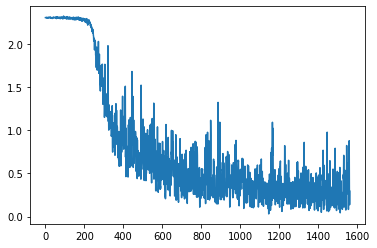

0.8091687524062364
[[ 0.15974826 -0.01439803  0.02722345 ...  0.12441444 -0.08657503
  -0.08908821]
 [ 0.16521974 -0.11576226 -0.02322394 ...  0.16608091 -0.07410986
  -0.01224184]
 [ 0.31647986 -0.40144398  0.28975802 ... -0.07281758  0.03740608
  -0.08042999]
 ...
 [ 0.25269524 -0.17965274 -0.05790128 ...  0.10129656 -0.23172809
   0.02916122]
 [-0.09016651  0.03281553  0.18154096 ...  0.09109691 -0.05961313
  -0.08799257]
 [ 0.08933139 -0.11291522  0.22085014 ... -0.02355267 -0.05076605
  -0.00441156]]


In [8]:
batchsize=32
mean_loss_array= [] 
mean_batch_array = []
X = X_train
y = y_train
for batch_start in range(0, X.shape[0], batchsize):
    
    #print(y[batch_start : batch_start+batchsize])
    mean_loss2 =  train(network2, X=X[batch_start : batch_start+batchsize, : ],
                                   y=y[batch_start : batch_start+batchsize],
                                   regularise=False)
    mean_loss_array += [mean_loss2]
    mean_batch_array += [np.mean(X[batch_start : batch_start+batchsize, : ])]
plt.plot(mean_loss_array)
plt.show()
print(np.mean(mean_loss_array))
print(network2[-1].get_weights())
weights2_iter_1 = network2[-1].get_weights()

In [11]:
print(mean_batch_array)

[0.12521164715886354, 0.12836572128851542, 0.12924857442977192, 0.12698532538015206, 0.11917001175470189, 0.12966452205882353, 0.13475468312324929, 0.13275263230292117, 0.11867715836334534, 0.1254328293817527, 0.13072260154061624, 0.12114126900760305, 0.12124474789915968, 0.12309955232092838, 0.12686027536014405, 0.11877313425370147, 0.129531343787515, 0.12689732142857144, 0.11523203031212484, 0.12269517181872748, 0.13159920218087237, 0.12767888405362143, 0.14326918267306923, 0.1395545718287315, 0.1311859118647459, 0.13442439475790313, 0.13163828031212485, 0.13890071653661465, 0.13427245898359344, 0.12739799044617847, 0.130281487595038, 0.11583070728291317, 0.12039065626250503, 0.10611635279111643, 0.12153564550820325, 0.11466211484593837, 0.11550792191876753, 0.1597137292416967, 0.14540191076430573, 0.16936383928571427, 0.15221635529211686, 0.14719090761304524, 0.16629167291916766, 0.1614417642056823, 0.12817236269507803, 0.1264354179171669, 0.1261390493697479, 0.12236128826530611, 0.

In [9]:
print(mean_loss[:10])
print(mean_batch_array[:10])
assert np.all(mean_loss == mean_batch_array)
# THIS MEANS THE BATCH PARTS ARE EQUAL

[0.12521164715886354, 0.12836572128851542, 0.12924857442977192, 0.12698532538015206, 0.11917001175470189, 0.12966452205882353, 0.13475468312324929, 0.13275263230292117, 0.11867715836334534, 0.1254328293817527]
[0.12521164715886354, 0.12836572128851542, 0.12924857442977192, 0.12698532538015206, 0.11917001175470189, 0.12966452205882353, 0.13475468312324929, 0.13275263230292117, 0.11867715836334534, 0.1254328293817527]


In [10]:
print(weights_iter_1[:10])
print(weights2_iter_1[:10])
assert np.all(weights_iter_1 == weights2_iter_1)

[[ 1.30048011e-02 -5.62068931e-05  1.62391121e-03 -2.48806109e-02
  -1.02969486e-02  5.69630330e-03  7.35272402e-03 -7.05271018e-03
   3.77435439e-03  5.22834319e-03]
 [ 1.12567773e-02 -1.16845791e-02 -4.47662010e-03 -1.39140231e-02
  -8.65984093e-03 -2.27180095e-03  1.77466908e-03  2.04375699e-02
   4.88923306e-03  4.07654255e-03]
 [ 5.56302794e-03 -4.13557814e-02  1.70783811e-02  1.04623999e-02
  -4.90801387e-03 -2.26439517e-03  4.59754326e-03  1.59788955e-02
   1.78622996e-03 -2.46363792e-02]
 [-1.21874298e-02 -8.34530041e-03  1.56263681e-02  2.53043401e-02
  -1.52869735e-02 -1.42976113e-02  1.11396797e-02 -2.66342384e-02
   1.18666436e-02 -2.09478847e-02]
 [-1.27628440e-02  2.48210563e-03 -1.17103356e-02  1.54132673e-02
   1.04908802e-02  2.86676439e-03 -5.39953976e-04  2.35554164e-02
   1.31634179e-02  2.22140096e-02]
 [ 7.71273713e-03 -3.02455775e-02 -5.81606154e-03  4.19388958e-04
   7.97852689e-03  1.74335276e-02  6.71822278e-04  1.32097198e-02
  -1.56612913e-02 -1.05145925e-02

AssertionError: 